In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set OpenBLAS thread count
os.environ['OMP_NUM_THREADS'] = '1'

def prepare_compas_data(filepath):
    """Prepare COMPAS dataset with appropriate preprocessing"""
    df = pd.read_csv(filepath)
    
    # Select relevant features
    use_df = df[['sex', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'c_charge_degree', 'is_recid']]
    
    print("\nUnique age categories:", use_df['age_cat'].unique())
    
    # Create binary columns for sex
    encoded_df = use_df.copy()
    encoded_df['sex_Male'] = (use_df['sex'] == 'Male').astype(int)
    encoded_df['sex_Female'] = (use_df['sex'] == 'Female').astype(int)
    
    # Create binary columns for age
    encoded_df['age_cat_Greater_than_45'] = (use_df['age_cat'] == 'Greater than 45').astype(int)
    encoded_df['age_cat_Less_than_25'] = (use_df['age_cat'] == 'Less than 25').astype(int)
    encoded_df['age_cat_25_45'] = (use_df['age_cat'] == '25 - 45').astype(int)
    
    # Encode charge degree
    encoded_df = pd.get_dummies(encoded_df, columns=['c_charge_degree'], prefix='charge')
    
    # Encode race without dropping any category
    encoded_df = pd.get_dummies(encoded_df, columns=['race'], prefix='race')
    
    # Drop original categorical columns
    encoded_df = encoded_df.drop(columns=['sex', 'age_cat'])
    
    # Print columns for verification
    print("\nSex columns:", [col for col in encoded_df.columns if col.startswith('sex_')])
    print("Age columns:", [col for col in encoded_df.columns if col.startswith('age_cat_')])
    print("Race columns:", [col for col in encoded_df.columns if col.startswith('race_')])
    
    # Split features and target
    X = encoded_df.drop(columns=['is_recid'])
    y = encoded_df['is_recid']
    
    return X, y


def create_aif_dataset(df, label_name, protected_attribute_names):
    """Create an AIF360 dataset"""
    return BinaryLabelDataset(
        df=df,
        label_names=[label_name],
        protected_attribute_names=protected_attribute_names
    )

def analyze_fairness_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups, model_name=""):
    """Analyze fairness metrics using AIF360"""
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    # print(f"\n=== Fairness Metrics for {model_name} ===")
    
    # # Group Fairness Metrics
    # print("\nGroup Fairness Metrics:")
    # print(f"Disparate Impact: {metrics.disparate_impact():.3f}")
    # print(f"Statistical Parity Difference: {metrics.statistical_parity_difference():.3f}")
    
    # # Equal Opportunity Metrics
    # print("\nEqual Opportunity Metrics:")
    # print(f"Equal Opportunity Difference: {metrics.equal_opportunity_difference():.3f}")
    # print(f"Average Odds Difference: {metrics.average_odds_difference():.3f}")
    
    # # Privileged Group Metrics
    # print("\nPrivileged Group Metrics:")
    # print(f"True Positive Rate: {metrics.true_positive_rate(privileged=True):.3f}")
    # print(f"False Positive Rate: {metrics.false_positive_rate(privileged=True):.3f}")
    # print(f"True Negative Rate: {metrics.true_negative_rate(privileged=True):.3f}")
    # print(f"False Negative Rate: {metrics.false_negative_rate(privileged=True):.3f}")
    # print(f"Positive Predictive Value: {metrics.positive_predictive_value(privileged=True):.3f}")
    
    # # Unprivileged Group Metrics
    # print("\nUnprivileged Group Metrics:")
    # print(f"True Positive Rate: {metrics.true_positive_rate(privileged=False):.3f}")
    # print(f"False Positive Rate: {metrics.false_positive_rate(privileged=False):.3f}")
    # print(f"True Negative Rate: {metrics.true_negative_rate(privileged=False):.3f}")
    # print(f"False Negative Rate: {metrics.false_negative_rate(privileged=False):.3f}")
    # print(f"Positive Predictive Value: {metrics.positive_predictive_value(privileged=False):.3f}")
    
    return metrics


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


# XGB for Impact Parity

In [240]:
class CompasImpactParityXGBoost:
    def __init__(self, fairness_weight=0.3, impact_threshold=0.8):
        self.fairness_weight = fairness_weight
        self.impact_threshold = impact_threshold
        self.base_params = {
                'max_depth': 3,
                'learning_rate': 0.1,
                'n_estimators': 200,
                'objective': None
            }
        self.model = None
        self.protected_attributes = None
        
    def _compute_fairness_penalty(self, y_pred):
        y_pred_binary = (y_pred > 0.5).astype(int)
        privileged_mask = self.protected_attributes == 1
        unprivileged_mask = ~privileged_mask
        
        priv_positive_rate = np.mean(y_pred_binary[privileged_mask])
        unpriv_positive_rate = np.mean(y_pred_binary[unprivileged_mask])
        
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        impact_ratio = (unpriv_positive_rate + epsilon) / (priv_positive_rate + epsilon)
            
        # Clip the impact ratio to prevent extreme values
        impact_ratio = np.clip(impact_ratio, 0.1, 20.0)
            
        # Modified penalty calculation with better scaling
        if impact_ratio > (1/self.impact_threshold):
            penalty = np.minimum(
                (impact_ratio - 1/self.impact_threshold) * 0.1,  # Scale down the penalty
                1.0  # Cap the maximum penalty
            )
        else:
            penalty = np.minimum(
                abs(1.0 - impact_ratio) * 0.1,  # Scale down the penalty
                1.5  # Cap the maximum penalty
            )
            
        # For debugging
        if np.random.random() < 0.01:  # Print only 1% of the time to avoid flooding
            print(f"Impact Ratio: {impact_ratio:.3f}, Penalty: {penalty:.3f}")
        
        return penalty
    
    
    def _fair_objective(self, y_pred, dtrain):
        y_true = dtrain.get_label()
        grad = y_pred - y_true
        # hess = y_pred * (1 - y_pred)
        hess = np.ones(len(y_pred))
        fairness_penalty = self._compute_fairness_penalty(y_pred)
        grad += self.fairness_weight * fairness_penalty
        return grad, hess
    
    def fit(self, X, y, protected_attributes):
        self.protected_attributes = protected_attributes
        dtrain = xgb.DMatrix(X, label=y)
        self.model = xgb.train(self.base_params, dtrain, obj=self._fair_objective)
    
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return (self.model.predict(dtest) > 0.5).astype(int)

# Smote

In [241]:
def resample_demographic(X, y, feature_prefix, sampling_algorithm='SMOTE'):
    """
    Resample data so that each group under the feature has equal numbers of 0s and 1s
    """
    feature_cols = [col for col in X.columns if col.startswith(feature_prefix)]
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    
    # Process each group
    for col in feature_cols:
        mask = X[col] == 1
        X_group = X[mask]
        y_group = y[mask]
        
        if len(X_group) == 0:
            continue
            
        print(f"\nProcessing {col}:")
        print(f"Original counts:")
        print(pd.Series(y_group).value_counts())
        
        # Get the count of the majority class
        target_count = max(sum(y_group == 0), sum(y_group == 1))
        
        # Set sampling strategy to make both classes equal to the majority class
        sampling_strategy = {0: target_count, 1: target_count}
        
        try:
            if sampling_algorithm == 'SMOTE':
                pipeline = Pipeline([
                    ('oversample', SMOTE(
                        sampling_strategy=sampling_strategy,
                        k_neighbors=min(5, len(X_group)-1),
                        random_state=42
                    ))
                ])
            elif sampling_algorithm == 'ADASYN':
                pipeline = Pipeline([
                    ('oversample', ADASYN(
                        sampling_strategy=sampling_strategy,
                        n_neighbors=min(5, len(X_group)-1),
                        random_state=42
                    ))
                ])
            
            X_res, y_res = pipeline.fit_resample(X_group, y_group)
            print(f"Resampled counts:")
            print(pd.Series(y_res).value_counts())
            
            resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
            resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
            
        except ValueError as e:
            print(f"Warning: Skipping group due to insufficient samples: {e}")
            resampled_X = pd.concat([resampled_X, X_group])
            resampled_y = pd.concat([resampled_y, y_group])
    
    return resampled_X.reset_index(drop=True), resampled_y.reset_index(drop=True)


def balanced_resample_compas(X, y, protected_attribute):
    """
    COMPAS-specific resampling with SMOTE
    """
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    resampled_protected = []
    
    for group in [0, 1]:
        mask = X[protected_attribute] == group
        X_group = X[mask]
        y_group = y[mask]
        
        
        pipeline = Pipeline([
            ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)),
            ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=42))
            ])
        
        
        X_res, y_res = pipeline.fit_resample(X_group, y_group)
        resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
        resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
        resampled_protected.extend([group] * len(y_res))
    
    return resampled_X.reset_index(drop=True), resampled_y.reset_index(drop=True), np.array(resampled_protected)


In [242]:
def evaluate_model(model_name, model, X_test, y_test, protected_groups):
    """
    Evaluate model performance and fairness
    """
    predictions = model.predict(X_test)
    
    print(f"\n=== {model_name} Performance ===")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    
    # Create datasets for fairness analysis
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = predictions
    
    for attr_type, group_info in protected_groups.items():
        dataset_true = create_aif_dataset(test_df, 'label', group_info['attributes'])
        dataset_pred = create_aif_dataset(pred_df, 'label', group_info['attributes'])
        
        analyze_fairness_metrics(
            dataset_true,
            dataset_pred,
            group_info['privileged'],
            group_info['unprivileged'],
            f"{model_name} - {attr_type}"
        )


# Load and prepare data
print("Loading and preparing COMPAS dataset...")
X, y = prepare_compas_data('compas-scores-two-years.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define protected groups
protected_groups = {
    'race': {
        'privileged': [{'race_Caucasian': 1}],
        'unprivileged': [{'race_African-American': 1}],
        'attributes': ['race_African-American', 'race_Caucasian', 'race_Asian', 'race_Hispanic', 'race_Native American', 'race_Other']
    },
    'sex': {
        'privileged': [{'sex_Female': 1}],
        'unprivileged': [{'sex_Male': 1}],
        'attributes': ['sex_Male', 'sex_Female']
    },
    'age': {
        'privileged': [{'age_cat_Greater_than_45': 1}],
        'unprivileged': [{'age_cat_Less_than_25': 1}],
        'attributes': ['age_cat_Greater_than_45', 'age_cat_Less_than_25', 'age_cat_25_45']
    }
}

In [243]:

# Load and prepare data
print("Loading and preparing COMPAS dataset...")
X, y = prepare_compas_data('compas-scores-two-years.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define protected groups
protected_groups = {
    'race': {
        'privileged': [{'race_Caucasian': 1}],
        'unprivileged': [{'race_African-American': 1}],
        'attributes': ['race_African-American', 'race_Caucasian']
    },
    'sex': {
        'privileged': [{'sex_Male': 0}],
        'unprivileged': [{'sex_Male': 1}],
        'attributes': ['sex_Male']
    },
    'age': {
        'privileged': [{'age_cat_Greater_than_45': 1}],
        'unprivileged': [{'age_cat_Less_than_25': 1}],
        'attributes': ['age_cat_Greater_than_45', 'age_cat_Less_than_25', 'age_cat_25_45']
    }
}

Loading and preparing COMPAS dataset...

Unique age categories: ['Greater than 45' '25 - 45' 'Less than 25']

Sex columns: ['sex_Male', 'sex_Female']
Age columns: ['age_cat_Greater_than_45', 'age_cat_Less_than_25', 'age_cat_25_45']
Race columns: ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']


# 1. Regular XGBoost

In [244]:
# 1. Regular XGBoost
print("\nTraining regular XGBoost...")
regular_xgb = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
regular_xgb.fit(X_train, y_train)
evaluate_model("Regular XGBoost", regular_xgb, X_test, y_test, protected_groups)



Training regular XGBoost...

=== Regular XGBoost Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1153
           1       0.67      0.67      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165



# 2. SMOTE-based approach for each protected attribute

In [215]:
print(f"\nTraining SMOTE-based XGBoost for race_African-American...")
# race_African-American
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'race_', 'SMOTE')
# X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, 'race_African-American')
smote_xgb_race = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
smote_xgb_race.fit(X_resampled, y_resampled)
evaluate_model(f"SMOTE XGBoost - race_African-American", smote_xgb_race, X_test, y_test, protected_groups)


Training SMOTE-based XGBoost for race_African-American...

Processing race_African-American:
Original counts:
1    1425
0    1159
Name: is_recid, dtype: int64
Resampled counts:
0    1425
1    1425
Name: is_recid, dtype: int64

Processing race_Asian:
Original counts:
0    17
1     9
Name: is_recid, dtype: int64
Resampled counts:
0    17
1    17
Name: is_recid, dtype: int64

Processing race_Caucasian:
Original counts:
0    981
1    733
Name: is_recid, dtype: int64
Resampled counts:
1    981
0    981
Name: is_recid, dtype: int64

Processing race_Hispanic:
Original counts:
0    270
1    184
Name: is_recid, dtype: int64
Resampled counts:
0    270
1    270
Name: is_recid, dtype: int64

Processing race_Native American:
Original counts:
1    9
0    6
Name: is_recid, dtype: int64
Resampled counts:
1    9
0    9
Name: is_recid, dtype: int64

Processing race_Other:
Original counts:
0    157
1     99
Name: is_recid, dtype: int64
Resampled counts:
0    157
1    157
Name: is_recid, dtype: int64

==

In [216]:
print(f"\nTraining SMOTE-based XGBoost for sex_Male...")
# sex_Male
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'sex_', 'SMOTE')
# X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, 'sex_Male')
smote_xgb_sex = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
smote_xgb_sex.fit(X_resampled, y_resampled)
evaluate_model(f"SMOTE XGBoost - sex_Male", smote_xgb_sex, X_test, y_test, protected_groups)


Training SMOTE-based XGBoost for sex_Male...

Processing sex_Male:
Original counts:
1    2074
0    1977
Name: is_recid, dtype: int64
Resampled counts:
1    2074
0    2074
Name: is_recid, dtype: int64

Processing sex_Female:
Original counts:
0    613
1    385
Name: is_recid, dtype: int64
Resampled counts:
0    613
1    613
Name: is_recid, dtype: int64

=== SMOTE XGBoost - sex_Male Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1153
           1       0.66      0.66      0.66      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.68      0.68      0.68      2165



In [217]:
print(f"\nTraining SMOTE-based XGBoost for age_cat_Greater_than_45...")
# age_cat_Greater_than_45
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'age_cat_', 'SMOTE')
# X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, 'age_cat_Greater_than_45')
smote_xgb_age = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
smote_xgb_age.fit(X_resampled, y_resampled)
evaluate_model(f"SMOTE XGBoost - age_cat_Greater than 45", smote_xgb_age, X_test, y_test, protected_groups)



Training SMOTE-based XGBoost for age_cat_Greater_than_45...

Processing age_cat_Greater_than_45:
Original counts:
0    722
1    398
Name: is_recid, dtype: int64
Resampled counts:
0    722
1    722
Name: is_recid, dtype: int64

Processing age_cat_Less_than_25:
Original counts:
1    625
0    437
Name: is_recid, dtype: int64
Resampled counts:
0    625
1    625
Name: is_recid, dtype: int64

Processing age_cat_25_45:
Original counts:
1    1436
0    1431
Name: is_recid, dtype: int64
Resampled counts:
1    1436
0    1436
Name: is_recid, dtype: int64

=== SMOTE XGBoost - age_cat_Greater than 45 Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.71      1153
           1       0.67      0.62      0.64      1012

    accuracy                           0.68      2165
   macro avg       0.67      0.67      0.67      2165
weighted avg       0.68      0.68      0.67      2165



# 3. ADASYN-based approach for each protected attribute

In [218]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report



def train_adasyn_model(X_train, y_train, attr, random_state=42):
    """
    Train XGBoost with ADASYN sampling for a specific protected attribute
    """
    # Create combined labels that consider both protected attribute and target
    protected = X_train[attr].values
    combined_labels = protected * 2 + y_train  # Creates 4 classes: (0,0), (0,1), (1,0), (1,1)
    
    print("\nOriginal distribution:")
    print("Protected attribute distribution:")
    print(pd.Series(protected).value_counts())
    print("\nTarget distribution within protected groups:")
    print(pd.DataFrame({'protected': protected, 'target': y_train})
          .groupby(['protected', 'target']).size().unstack(fill_value=0))
    
    try:
        # Initialize ADASYN with careful parameter tuning
        adasyn = ADASYN(
            sampling_strategy='minority',
            random_state=random_state,
            n_neighbors=min(5, pd.Series(combined_labels).value_counts().min() - 1)
        )
        
        # Perform ADASYN sampling on the combined labels
        X_resampled, combined_labels_resampled = adasyn.fit_resample(X_train, combined_labels)
        
        # Convert back to separate protected attribute and target
        protected_resampled = (combined_labels_resampled >= 2).astype(int)
        y_resampled = combined_labels_resampled % 2
        
        print("\nResampled distribution:")
        print("Protected attribute distribution:")
        print(pd.Series(protected_resampled).value_counts())
        print("\nTarget distribution within protected groups:")
        print(pd.DataFrame({'protected': protected_resampled, 'target': y_resampled})
              .groupby(['protected', 'target']).size().unstack(fill_value=0))
        
    except ValueError as e:
        print(f"\nADASYN failed: {e}")
        print("Falling back to original data...")
        X_resampled, y_resampled, protected_resampled = X_train, y_train, protected
    
    # Train XGBoost on resampled data
    adasyn_xgb = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200,
        objective='binary:logistic',
        random_state=random_state
    )
    adasyn_xgb.fit(X_resampled, y_resampled)
    
    return adasyn_xgb, X_resampled, y_resampled

In [219]:
# 1. ADASYN for race
print("\nTraining ADASYN-based XGBoost for race_African-American...")
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'race_African-American', 'ADASYN')
adasyn_xgb_race = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic',
    random_state=42
)
adasyn_xgb_race.fit(X_resampled, y_resampled)
evaluate_model("ADASYN XGBoost - race", adasyn_xgb_race, X_test, y_test, protected_groups)


Training ADASYN-based XGBoost for race_African-American...

Processing race_African-American:
Original counts:
1    1425
0    1159
Name: is_recid, dtype: int64
Resampled counts:
1    1425
0    1214
Name: is_recid, dtype: int64

=== ADASYN XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1153
           1       0.67      0.68      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165



In [220]:
# 2. ADASYN for sex
print("\nTraining ADASYN-based XGBoost for sex_Male...")
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'sex_Male', 'ADASYN')
adasyn_xgb_sex = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic',
    random_state=42
)
adasyn_xgb_sex.fit(X_resampled, y_resampled)
evaluate_model("ADASYN XGBoost - sex", adasyn_xgb_sex, X_test, y_test, protected_groups)


Training ADASYN-based XGBoost for sex_Male...

Processing sex_Male:
Original counts:
1    2074
0    1977
Name: is_recid, dtype: int64

=== ADASYN XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      1153
           1       0.66      0.69      0.68      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165



In [221]:
# 3. ADASYN for age
print("\nTraining ADASYN-based XGBoost for age_cat_Greater_than_45...")
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'age_cat_Greater_than_45', 'ADASYN')
adasyn_xgb_age = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic',
    random_state=42
)
adasyn_xgb_age.fit(X_resampled, y_resampled)
evaluate_model("ADASYN XGBoost - age", adasyn_xgb_age, X_test, y_test, protected_groups)


Training ADASYN-based XGBoost for age_cat_Greater_than_45...

Processing age_cat_Greater_than_45:
Original counts:
0    722
1    398
Name: is_recid, dtype: int64
Resampled counts:
0    722
1    714
Name: is_recid, dtype: int64

=== ADASYN XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1153
           1       0.65      0.56      0.60      1012

    accuracy                           0.65      2165
   macro avg       0.65      0.65      0.65      2165
weighted avg       0.65      0.65      0.65      2165



# 4. Fair XGBoost for each protected attribute

In [222]:
# Fair XGBoost for race
print("\nTraining Fair XGBoost for race...")
fair_xgb_race = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.8)
fair_xgb_race.fit(X_train, y_train, X_train['race_African-American'].values)
evaluate_model("Fair XGBoost - race", fair_xgb_race, X_test, y_test, protected_groups)


Training Fair XGBoost for race...

=== Fair XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      1153
           1       0.66      0.69      0.68      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165



c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [223]:
# Fair XGBoost for sex
print("\nTraining Fair XGBoost for sex...")
fair_xgb_sex = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.8)
fair_xgb_sex.fit(X_train, y_train, X_train['sex_Male'].values)
evaluate_model("Fair XGBoost - sex", fair_xgb_sex, X_test, y_test, protected_groups)


Training Fair XGBoost for sex...

=== Fair XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      1153
           1       0.66      0.69      0.68      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165



c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [224]:
X_train.head()
X_train.shape
X_train.columns
# X_train.info()
# X_train.describe()
X_train['age_cat_Greater_than_45'].value_counts()

# Fair XGBoost for age
print("\nTraining Fair XGBoost for age...")
# print(X_train['age_cat_Greater than 45'].values)
fair_xgb_age = CompasImpactParityXGBoost(fairness_weight=0.3, impact_threshold=0.8)
fair_xgb_age.fit(X_train, y_train, X_train['age_cat_Greater_than_45'].values)
evaluate_model("Fair XGBoost - age", fair_xgb_age, X_test, y_test, protected_groups)



Training Fair XGBoost for age...

=== Fair XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      1153
           1       0.69      0.57      0.62      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.67      0.67      2165
weighted avg       0.68      0.68      0.68      2165



c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


# 5. Combined SMOTE + Fair XGBoost for each protected attribute

In [225]:
print("\nTraining Combined SMOTE + Fair XGBoost for race...")
# race_African-American
X_resampled_race, y_resampled_race = resample_demographic(X_train, y_train, 'race_', 'SMOTE')   
# X_resampled_race, y_resampled_race, protected_resampled_race = balanced_resample_compas(X_train, y_train, 'race_African-American')
protected_resampled_race = X_resampled_race['race_African-American'].values
# combined_xgb_race = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.9)
combined_xgb_race = CompasImpactParityXGBoost(fairness_weight=0.3, impact_threshold=0.8)
combined_xgb_race.fit(X_resampled_race, y_resampled_race, protected_resampled_race)
evaluate_model("Combined SMOTE + Fair XGBoost - race", combined_xgb_race, X_test, y_test, protected_groups)


Training Combined SMOTE + Fair XGBoost for race...

Processing race_African-American:
Original counts:
1    1425
0    1159
Name: is_recid, dtype: int64
Resampled counts:
0    1425
1    1425
Name: is_recid, dtype: int64

Processing race_Asian:
Original counts:
0    17
1     9
Name: is_recid, dtype: int64
Resampled counts:
0    17
1    17
Name: is_recid, dtype: int64

Processing race_Caucasian:
Original counts:
0    981
1    733
Name: is_recid, dtype: int64
Resampled counts:
1    981
0    981
Name: is_recid, dtype: int64

Processing race_Hispanic:
Original counts:
0    270
1    184
Name: is_recid, dtype: int64
Resampled counts:
0    270
1    270
Name: is_recid, dtype: int64

Processing race_Native American:
Original counts:
1    9
0    6
Name: is_recid, dtype: int64
Resampled counts:
1    9
0    9
Name: is_recid, dtype: int64

Processing race_Other:
Original counts:
0    157
1     99
Name: is_recid, dtype: int64
Resampled counts:
0    157
1    157
Name: is_recid, dtype: int64

=== Combi

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.74      0.60      0.66      1153
           1       0.62      0.76      0.68      1012

    accuracy                           0.67      2165
   macro avg       0.68      0.68      0.67      2165
weighted avg       0.68      0.67      0.67      2165



In [226]:
# Combined SMOTE + Fair XGBoost for sex
print("\nTraining Combined SMOTE + Fair XGBoost for sex...")
# sex_Male
X_resampled_sex, y_resampled_sex = resample_demographic(X_train, y_train, 'sex_', 'SMOTE')  
# X_resampled_sex, y_resampled_sex, protected_resampled_sex = balanced_resample_compas(X_train, y_train, 'sex_Male')
protected_resampled_sex = X_resampled_sex['sex_Male'].values
combined_xgb_sex = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.8)
combined_xgb_sex.fit(X_resampled_sex, y_resampled_sex, protected_resampled_sex)
evaluate_model("Combined SMOTE + Fair XGBoost - sex", combined_xgb_sex, X_test, y_test, protected_groups)


Training Combined SMOTE + Fair XGBoost for sex...

Processing sex_Male:
Original counts:
1    2074
0    1977
Name: is_recid, dtype: int64
Resampled counts:
1    2074
0    2074
Name: is_recid, dtype: int64

Processing sex_Female:
Original counts:
0    613
1    385
Name: is_recid, dtype: int64
Resampled counts:
0    613
1    613
Name: is_recid, dtype: int64

=== Combined SMOTE + Fair XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      1153
           1       0.65      0.64      0.64      1012

    accuracy                           0.67      2165
   macro avg       0.66      0.66      0.66      2165
weighted avg       0.67      0.67      0.67      2165



c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [227]:
# Combined SMOTE + Fair XGBoost for age
print("\nTraining Combined SMOTE + Fair XGBoost for age...")
# age_cat_Greater_than_45
X_resampled_age, y_resampled_age = resample_demographic(X_train, y_train, 'age_cat_', 'SMOTE')
# X_resampled_age, y_resampled_age, protected_resampled_age = balanced_resample_compas(X_train, y_train, 'age_cat_Greater_than_45')
protected_resampled_age = X_resampled_age['age_cat_Greater_than_45'].values
# combined_xgb_age = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.8)
combined_xgb_age = CompasImpactParityXGBoost(fairness_weight=0.25, impact_threshold=0.8)
combined_xgb_age.fit(X_resampled_age, y_resampled_age, protected_resampled_age)
evaluate_model("Combined SMOTE + Fair XGBoost - age", combined_xgb_age, X_test, y_test, protected_groups)


Training Combined SMOTE + Fair XGBoost for age...

Processing age_cat_Greater_than_45:
Original counts:
0    722
1    398
Name: is_recid, dtype: int64
Resampled counts:
0    722
1    722
Name: is_recid, dtype: int64

Processing age_cat_Less_than_25:
Original counts:
1    625
0    437
Name: is_recid, dtype: int64
Resampled counts:
0    625
1    625
Name: is_recid, dtype: int64

Processing age_cat_25_45:
Original counts:
1    1436
0    1431
Name: is_recid, dtype: int64
Resampled counts:
1    1436
0    1436
Name: is_recid, dtype: int64


c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



=== Combined SMOTE + Fair XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1153
           1       0.66      0.62      0.64      1012

    accuracy                           0.67      2165
   macro avg       0.67      0.67      0.67      2165
weighted avg       0.67      0.67      0.67      2165



# 6. Combined ADASYN + Fair XGBoost for each protected attribute

In [228]:
# Combined ADASYN + Fair XGBoost for race
print("\nTraining Combined ADASYN + Fair XGBoost for race...")
# First apply ADASYN
# race_African-American
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'race_', 'ADASYN')
protected_resampled_race = X_resampled['race_African-American'].values

# Then apply Fair XGBoost on resampled data
combined_adasyn_fair_xgb_race = CompasImpactParityXGBoost(
    fairness_weight=0.2, impact_threshold=0.8)

combined_adasyn_fair_xgb_race.fit(X_resampled, y_resampled, protected_resampled_race)
evaluate_model("Combined ADASYN + Fair XGBoost - race", combined_adasyn_fair_xgb_race, X_test, y_test, protected_groups)

# X_resampled, y_resampled = resample_demographic(X_train, y_train, 'race', 'ADASYN')


Training Combined ADASYN + Fair XGBoost for race...

Processing race_African-American:
Original counts:
1    1425
0    1159
Name: is_recid, dtype: int64
Resampled counts:
1    1425
0    1214
Name: is_recid, dtype: int64

Processing race_Asian:
Original counts:
0    17
1     9
Name: is_recid, dtype: int64
Resampled counts:
0    17
1    14
Name: is_recid, dtype: int64

Processing race_Caucasian:
Original counts:
0    981
1    733
Name: is_recid, dtype: int64
Resampled counts:
0    981
1    977
Name: is_recid, dtype: int64

Processing race_Hispanic:
Original counts:
0    270
1    184
Name: is_recid, dtype: int64
Resampled counts:
1    276
0    270
Name: is_recid, dtype: int64

Processing race_Native American:
Original counts:
1    9
0    6
Name: is_recid, dtype: int64
Resampled counts:
1    9
0    7
Name: is_recid, dtype: int64

Processing race_Other:
Original counts:
0    157
1     99
Name: is_recid, dtype: int64
Resampled counts:
1    166
0    157
Name: is_recid, dtype: int64


c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



=== Combined ADASYN + Fair XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67      1153
           1       0.63      0.75      0.68      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.69      0.68      0.67      2165



In [229]:
# Combined ADASYN + Fair XGBoost for sex
print("\nTraining Combined ADASYN + Fair XGBoost for sex...")
# First apply ADASYN
# adasyn_xgb_sex, X_resampled_sex, y_resampled_sex = train_adasyn_model(X_train, y_train, 'sex_Male')
# sex_Male
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'sex_', 'ADASYN')
protected_resampled_sex = X_resampled['sex_Male'].values

# Then apply Fair XGBoost on resampled data
combined_adasyn_fair_xgb_sex = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.9)
combined_adasyn_fair_xgb_sex.fit(X_resampled, y_resampled, protected_resampled_sex)
evaluate_model("Combined ADASYN + Fair XGBoost - sex", combined_adasyn_fair_xgb_sex, X_test, y_test, protected_groups)



Training Combined ADASYN + Fair XGBoost for sex...

Processing sex_Male:
Original counts:
1    2074
0    1977
Name: is_recid, dtype: int64

Processing sex_Female:
Original counts:
0    613
1    385
Name: is_recid, dtype: int64
Resampled counts:
1    614
0    613
Name: is_recid, dtype: int64

=== Combined ADASYN + Fair XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1153
           1       0.67      0.68      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165



c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [230]:

# Combined ADASYN + Fair XGBoost for age
print("\nTraining Combined ADASYN + Fair XGBoost for age...")
# First apply ADASYN
# adasyn_xgb_age, X_resampled_age, y_resampled_age = train_adasyn_model(X_train, y_train, 'age_cat_Greater_than_45')
# 'age_cat_Greater_than_45'
X_resampled, y_resampled = resample_demographic(X_train, y_train, 'age_cat_', 'ADASYN')
protected_resampled_age = X_resampled['age_cat_Greater_than_45'].values

# Then apply Fair XGBoost on resampled data
combined_adasyn_fair_xgb_age = CompasImpactParityXGBoost(fairness_weight=0.25, impact_threshold=0.8)
combined_adasyn_fair_xgb_age.fit(X_resampled, y_resampled, protected_resampled_age)
evaluate_model("Combined ADASYN + Fair XGBoost - age", combined_adasyn_fair_xgb_age, X_test, y_test, protected_groups)


Training Combined ADASYN + Fair XGBoost for age...

Processing age_cat_Greater_than_45:
Original counts:
0    722
1    398
Name: is_recid, dtype: int64
Resampled counts:
0    722
1    714
Name: is_recid, dtype: int64

Processing age_cat_Less_than_25:
Original counts:
1    625
0    437
Name: is_recid, dtype: int64
Resampled counts:
0    653
1    625
Name: is_recid, dtype: int64

Processing age_cat_25_45:
Original counts:
1    1436
0    1431
Name: is_recid, dtype: int64

=== Combined ADASYN + Fair XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1153
           1       0.66      0.61      0.63      1012

    accuracy                           0.67      2165
   macro avg       0.67      0.67      0.67      2165
weighted avg       0.67      0.67      0.67      2165



c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


# Visualization ROC curve


In [231]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(models_dict, X_test, y_test):
    """
    Plot ROC curves for multiple models
    
    Parameters:
    models_dict: Dictionary of model names and fitted model objects
    X_test: Test features
    y_test: Test labels
    """
    plt.figure(figsize=(8, 6))
    
    for name, model in models_dict.items():
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            # For models that don't have predict_proba
            y_pred_proba = model.predict(X_test)
            
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

# models_dict = {
#     'Regular XGBoost': regular_xgb,
#     'SMOTE XGBoost - Race': smote_xgb_race,
#     'SMOTE XGBoost - Sex': smote_xgb_sex,
#     'SMOTE XGBoost - Age': smote_xgb_age,
#     'ADASYN XGBoost - Race': adasyn_xgb_race,
#     'ADASYN XGBoost - Sex': adasyn_xgb_sex,
#     'ADASYN XGBoost - Age': adasyn_xgb_age,
#     'Fair XGBoost - Race': fair_xgb_race,
#     'Fair XGBoost - Sex': fair_xgb_sex,
#     'Fair XGBoost - Age': fair_xgb_age,
#     'Combined SMOTE + Fair XGBoost - Race': combined_xgb_race,
#     'Combined SMOTE + Fair XGBoost - Sex': combined_xgb_sex,
#     'Combined SMOTE + Fair XGBoost - Age': combined_xgb_age
# }

# plot_roc_curves(models_dict, X_test, y_test)

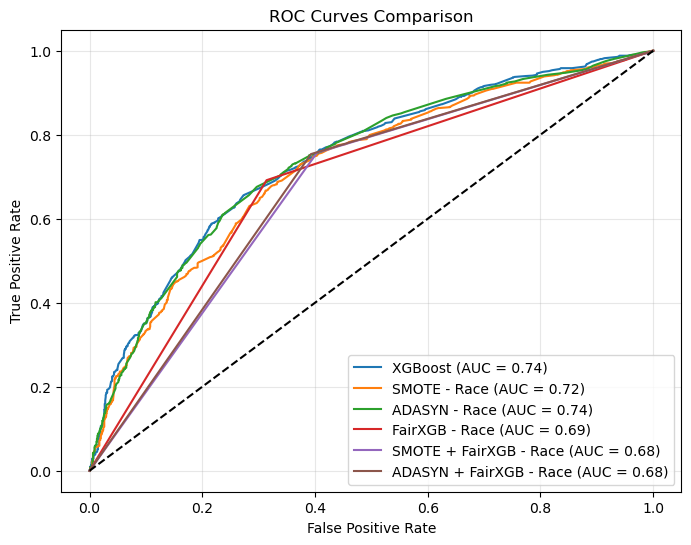

In [232]:
# Usage example
models_dict = {
    'XGBoost': regular_xgb,
    'SMOTE - Race': smote_xgb_race,
    # 'SMOTE XGBoost - Sex': smote_xgb_sex,
    # 'SMOTE XGBoost - Age': smote_xgb_age,
    'ADASYN - Race': adasyn_xgb_race,
    # 'ADASYN XGBoost - Sex': adasyn_xgb_sex,
    # 'ADASYN XGBoost - Age': adasyn_xgb_age,
    'FairXGB - Race': fair_xgb_race,
    # 'Fair XGBoost - Sex': fair_xgb_sex,
    # 'Fair XGBoost - Age': fair_xgb_age,
    'SMOTE + FairXGB - Race': combined_xgb_race,
    # 'Combined SMOTE + Fair XGBoost - Sex': combined_xgb_sex,
    # 'Combined SMOTE + Fair XGBoost - Age': combined_xgb_age,
    'ADASYN + FairXGB - Race': combined_adasyn_fair_xgb_race,
    # 'Combined ADASYN + Fair XGBoost - Sex': combined_adasyn_fair_xgb_sex,
    # 'Combined ADASYN + Fair XGBoost - Age': combined_adasyn_fair_xgb_age
}

plot_roc_curves(models_dict, X_test, y_test)

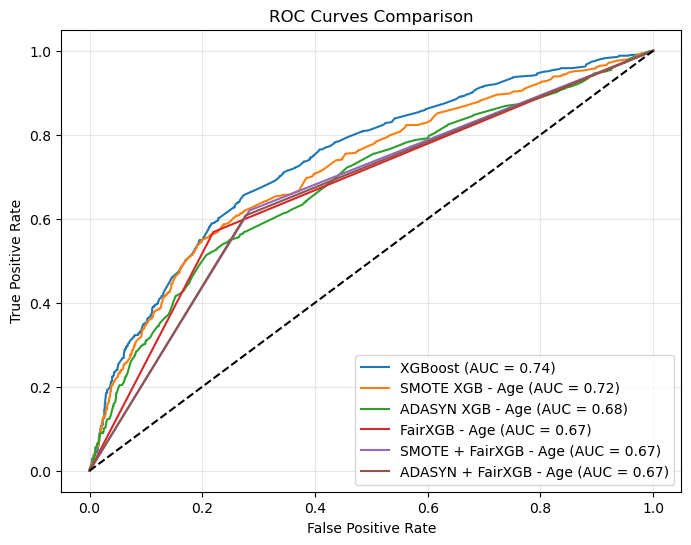

In [233]:
# Usage example
models_dict = {
    'XGBoost': regular_xgb,
    # 'SMOTE - Race': smote_xgb_race,
    # 'SMOTE XGB - Sex': smote_xgb_sex,
    'SMOTE XGB - Age': smote_xgb_age,
    # 'ADASYN - Race': adasyn_xgb_race,
    # 'ADASYN XGB - Sex': adasyn_xgb_sex,
    'ADASYN XGB - Age': adasyn_xgb_age,
    # 'FairXGB - Race': fair_xgb_race,
    # 'FairXGB - Sex': fair_xgb_sex,
    'FairXGB - Age': fair_xgb_age,
    # 'SMOTE + FairXGB - Race': combined_xgb_race,
    # 'SMOTE + FairXGB - Sex': combined_xgb_sex,
    'SMOTE + FairXGB - Age': combined_xgb_age,
    # 'ADASYN + FairXGB - Race': combined_adasyn_fair_xgb_race,
    # 'ADASYN + FairXGB - Sex': combined_adasyn_fair_xgb_sex,
    'ADASYN + FairXGB - Age': combined_adasyn_fair_xgb_age
}

plot_roc_curves(models_dict, X_test, y_test)

# Visualization Disparate Impact

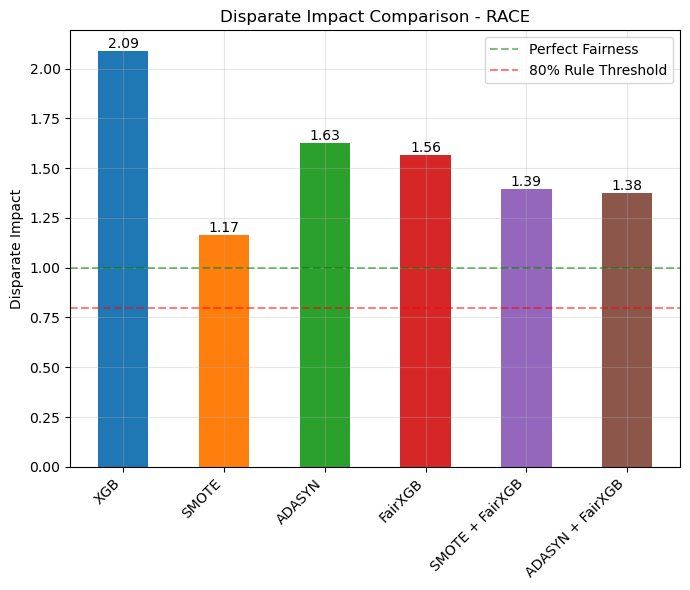

In [234]:
# Plot for Race
plt.figure(figsize=(7, 6))
models_dict_race = {
    'XGB': regular_xgb,
    'SMOTE': smote_xgb_race,
    'ADASYN': adasyn_xgb_race,
    'FairXGB': fair_xgb_race,
    'SMOTE + FairXGB': combined_xgb_race,
    'ADASYN + FairXGB': combined_adasyn_fair_xgb_race
}

disparate_impacts = []
method_names = []

for method_name, model in models_dict_race.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['race']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['race']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['race']['unprivileged'],
        privileged_groups=protected_groups['race']['privileged']
    )
    
    disparate_impacts.append(metrics.disparate_impact())
    method_names.append(method_name)

bars = plt.bar(range(len(method_names)), disparate_impacts, width=0.5, color=sns.color_palette())
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Fairness')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% Rule Threshold')

plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.title('Disparate Impact Comparison - RACE')
plt.ylabel('Disparate Impact')
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

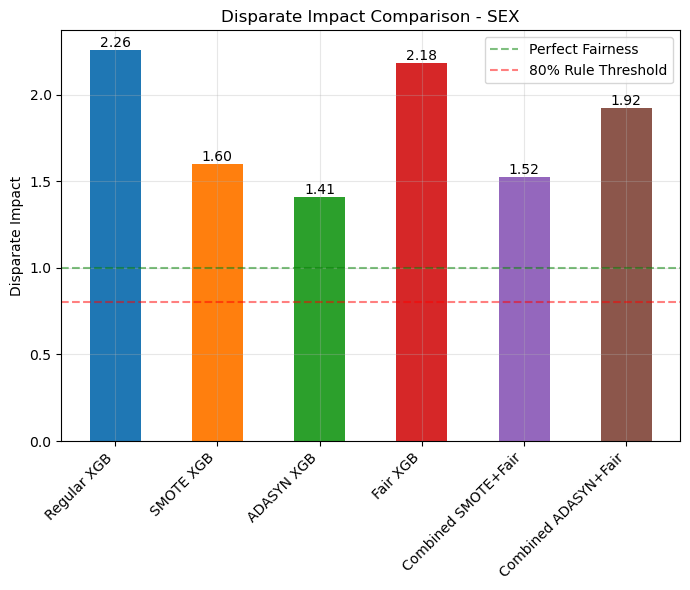

In [235]:
# Plot for Sex
plt.figure(figsize=(7, 6))
models_dict_sex = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB': smote_xgb_sex,
    'ADASYN XGB': adasyn_xgb_sex,
    'Fair XGB': fair_xgb_sex,
    'Combined SMOTE+Fair': combined_xgb_sex,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_sex
}

disparate_impacts = []
method_names = []

for method_name, model in models_dict_sex.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['sex']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['sex']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['sex']['unprivileged'],
        privileged_groups=protected_groups['sex']['privileged']
    )
    
    disparate_impacts.append(metrics.disparate_impact())
    method_names.append(method_name)

bars = plt.bar(range(len(method_names)), disparate_impacts, width=0.5, color=sns.color_palette())
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Fairness')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% Rule Threshold')

plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.title('Disparate Impact Comparison - SEX')
plt.ylabel('Disparate Impact')
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

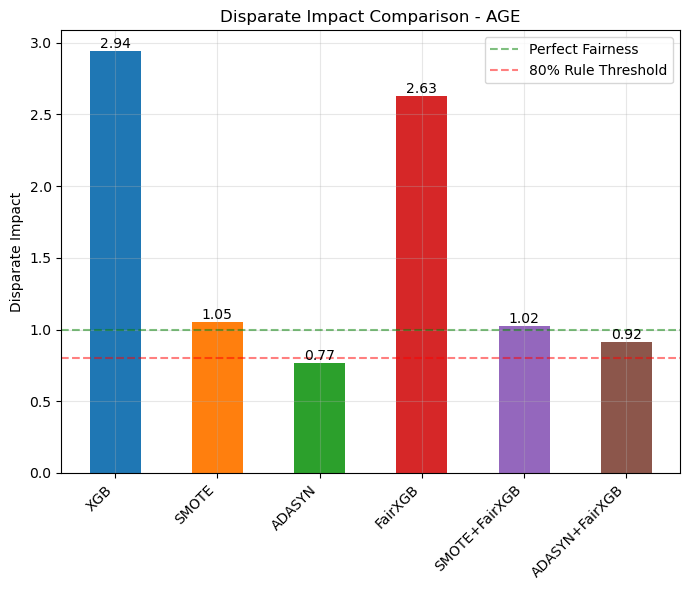

In [236]:
# Plot for Age
plt.figure(figsize=(7, 6))
models_dict_age = {
    'XGB': regular_xgb,
    'SMOTE': smote_xgb_age,
    'ADASYN': adasyn_xgb_age,
    'FairXGB': fair_xgb_age,
    'SMOTE+FairXGB': combined_xgb_age,
    'ADASYN+FairXGB': combined_adasyn_fair_xgb_age
}

disparate_impacts = []
method_names = []

for method_name, model in models_dict_age.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['age']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['age']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['age']['unprivileged'],
        privileged_groups=protected_groups['age']['privileged']
    )
    
    disparate_impacts.append(metrics.disparate_impact())
    method_names.append(method_name)

bars = plt.bar(range(len(method_names)), disparate_impacts, width=0.5, color=sns.color_palette())
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Fairness')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% Rule Threshold')

plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.title('Disparate Impact Comparison - AGE')
plt.ylabel('Disparate Impact')
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

## Visualize FPR, FNR

<Figure size 1500x600 with 0 Axes>

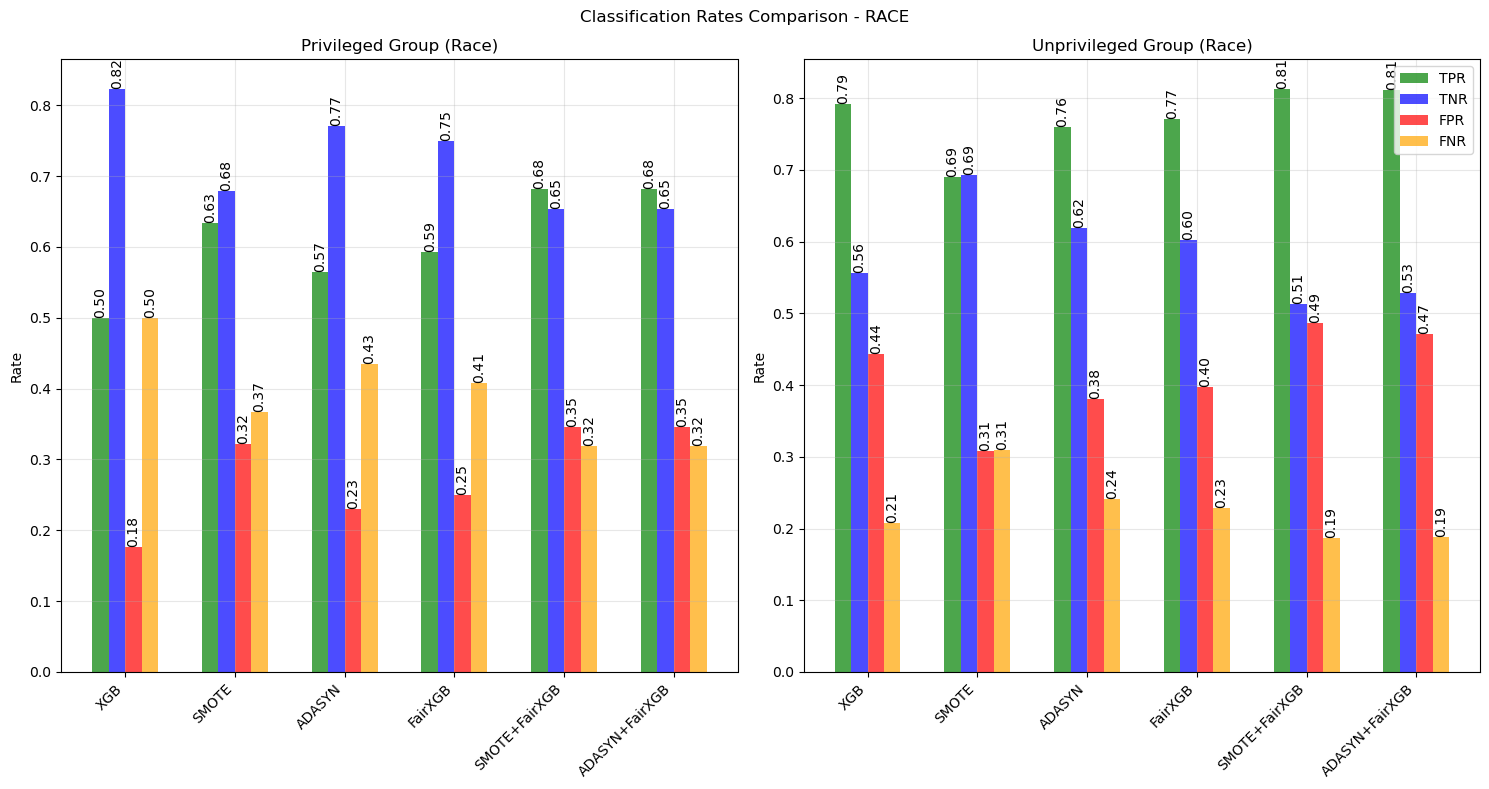

In [237]:
# Plot for Race
plt.figure(figsize=(15, 6))
models_dict_race = {
    'XGB': regular_xgb,
    'SMOTE': smote_xgb_race,
    'ADASYN': adasyn_xgb_race,
    'FairXGB': fair_xgb_race,
    'SMOTE+FairXGB': combined_xgb_race,
    'ADASYN+FairXGB': combined_adasyn_fair_xgb_race
}

rates_privileged = []
rates_unprivileged = []
method_names = []

for method_name, model in models_dict_race.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['race']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['race']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['race']['unprivileged'],
        privileged_groups=protected_groups['race']['privileged']
    )
    
    rates_privileged.append({
        'TPR': metrics.true_positive_rate(privileged=True),
        'TNR': metrics.true_negative_rate(privileged=True),
        'FPR': metrics.false_positive_rate(privileged=True),
        'FNR': metrics.false_negative_rate(privileged=True)
    })
    
    rates_unprivileged.append({
        'TPR': metrics.true_positive_rate(privileged=False),
        'TNR': metrics.true_negative_rate(privileged=False),
        'FPR': metrics.false_positive_rate(privileged=False),
        'FNR': metrics.false_negative_rate(privileged=False)
    })
    
    method_names.append(method_name)

df_privileged = pd.DataFrame(rates_privileged, index=method_names)
df_unprivileged = pd.DataFrame(rates_unprivileged, index=method_names)

# Plot
width = 0.15  # thinner bars
x = np.arange(len(method_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Privileged group plot
ax1.bar(x - 1.5*width, df_privileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax1.bar(x - 0.5*width, df_privileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax1.bar(x + 0.5*width, df_privileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax1.bar(x + 1.5*width, df_privileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax1.set_ylabel('Rate')
ax1.set_title('Privileged Group (Race)')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
# ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_privileged[metric]):
        ax1.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

# Unprivileged group plot
ax2.bar(x - 1.5*width, df_unprivileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax2.bar(x - 0.5*width, df_unprivileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax2.bar(x + 0.5*width, df_unprivileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax2.bar(x + 1.5*width, df_unprivileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax2.set_ylabel('Rate')
ax2.set_title('Unprivileged Group (Race)')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_unprivileged[metric]):
        ax2.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

plt.suptitle('Classification Rates Comparison - RACE')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

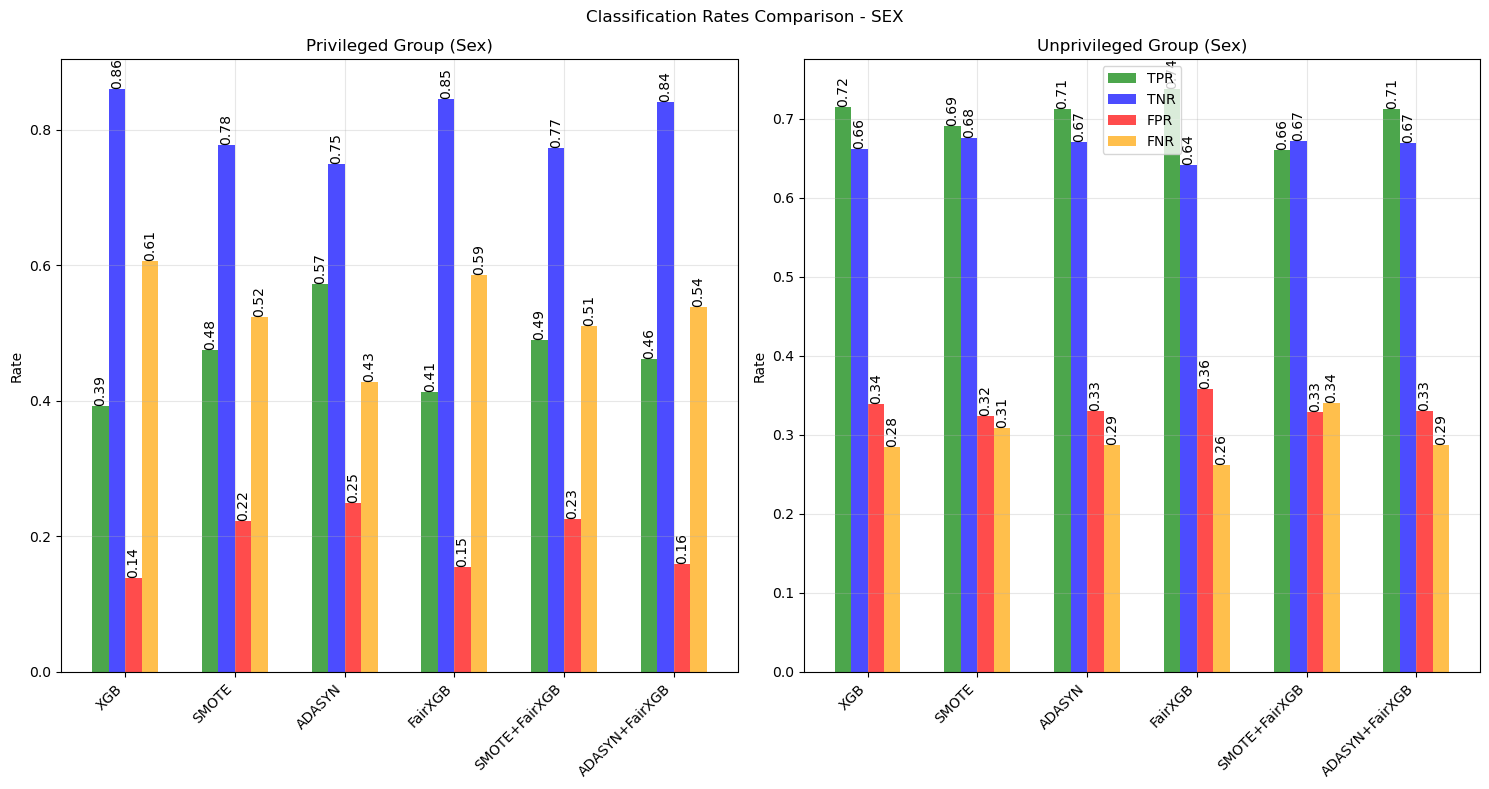

In [238]:
# Plot for Sex
plt.figure(figsize=(15, 8))
models_dict_sex = {
    'XGB': regular_xgb,
    'SMOTE': smote_xgb_sex,
    'ADASYN': adasyn_xgb_sex,
    'FairXGB': fair_xgb_sex,
    'SMOTE+FairXGB': combined_xgb_sex,
    'ADASYN+FairXGB': combined_adasyn_fair_xgb_sex
}

rates_privileged = []
rates_unprivileged = []
method_names = []

for method_name, model in models_dict_sex.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['sex']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['sex']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['sex']['unprivileged'],
        privileged_groups=protected_groups['sex']['privileged']
    )
    
    rates_privileged.append({
        'TPR': metrics.true_positive_rate(privileged=True),
        'TNR': metrics.true_negative_rate(privileged=True),
        'FPR': metrics.false_positive_rate(privileged=True),
        'FNR': metrics.false_negative_rate(privileged=True)
    })
    
    rates_unprivileged.append({
        'TPR': metrics.true_positive_rate(privileged=False),
        'TNR': metrics.true_negative_rate(privileged=False),
        'FPR': metrics.false_positive_rate(privileged=False),
        'FNR': metrics.false_negative_rate(privileged=False)
    })
    
    method_names.append(method_name)

df_privileged = pd.DataFrame(rates_privileged, index=method_names)
df_unprivileged = pd.DataFrame(rates_unprivileged, index=method_names)

width = 0.15
x = np.arange(len(method_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Privileged group plot
ax1.bar(x - 1.5*width, df_privileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax1.bar(x - 0.5*width, df_privileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax1.bar(x + 0.5*width, df_privileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax1.bar(x + 1.5*width, df_privileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax1.set_ylabel('Rate')
ax1.set_title('Privileged Group (Sex)')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
# ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_privileged[metric]):
        ax1.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

# Unprivileged group plot
ax2.bar(x - 1.5*width, df_unprivileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax2.bar(x - 0.5*width, df_unprivileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax2.bar(x + 0.5*width, df_unprivileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax2.bar(x + 1.5*width, df_unprivileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax2.set_ylabel('Rate')
ax2.set_title('Unprivileged Group (Sex)')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_unprivileged[metric]):
        ax2.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

plt.suptitle('Classification Rates Comparison - SEX')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

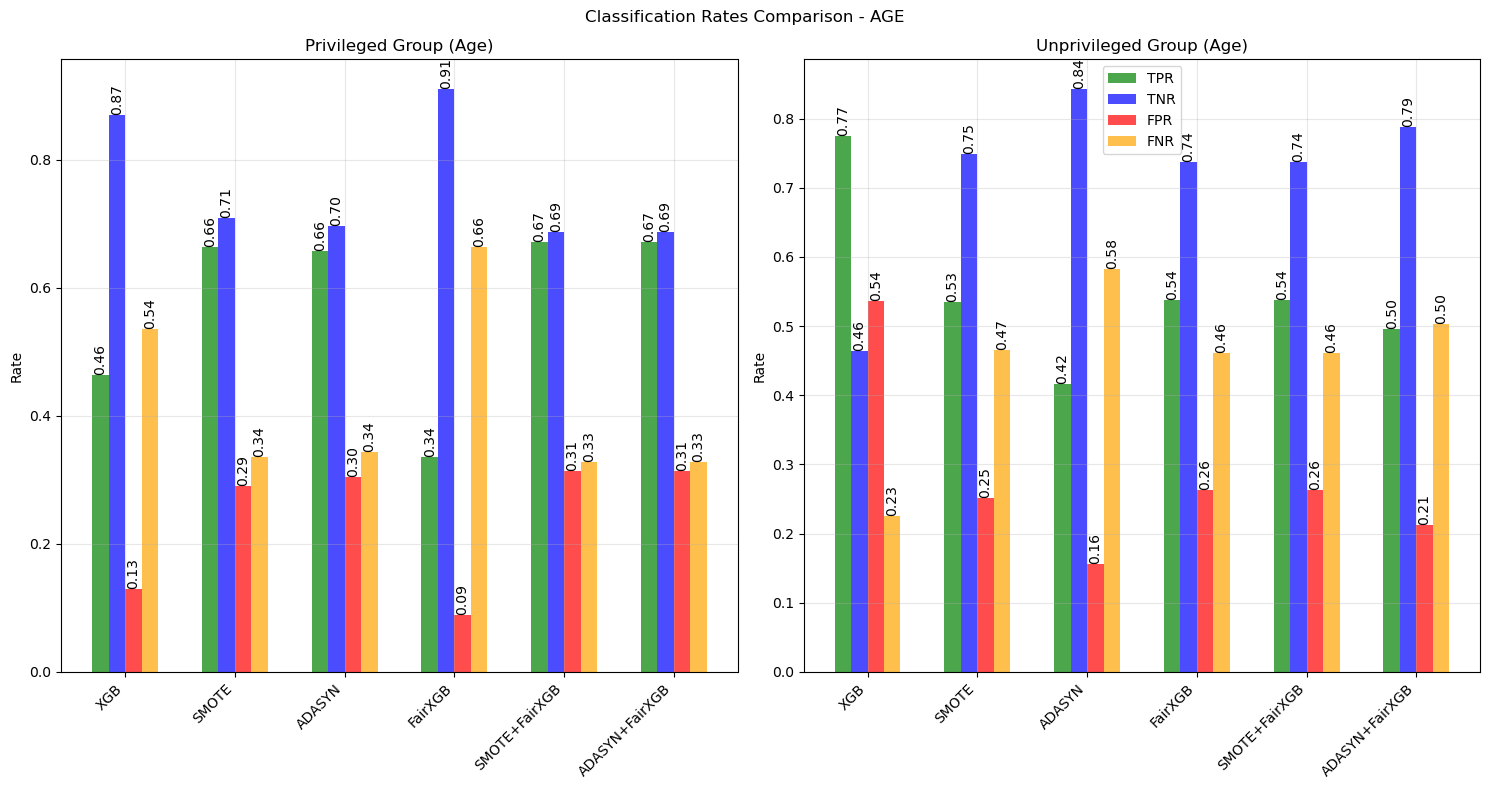

In [239]:
# Plot for Age
plt.figure(figsize=(15, 8))
models_dict_age = {
    'XGB': regular_xgb,
    'SMOTE': smote_xgb_age,
    'ADASYN': adasyn_xgb_age,
    'FairXGB': fair_xgb_age,
    'SMOTE+FairXGB': combined_xgb_age,
    'ADASYN+FairXGB': combined_adasyn_fair_xgb_age
}

rates_privileged = []
rates_unprivileged = []
method_names = []

for method_name, model in models_dict_age.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['age']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['age']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['age']['unprivileged'],
        privileged_groups=protected_groups['age']['privileged']
    )
    
    rates_privileged.append({
        'TPR': metrics.true_positive_rate(privileged=True),
        'TNR': metrics.true_negative_rate(privileged=True),
        'FPR': metrics.false_positive_rate(privileged=True),
        'FNR': metrics.false_negative_rate(privileged=True)
    })
    
    rates_unprivileged.append({
        'TPR': metrics.true_positive_rate(privileged=False),
        'TNR': metrics.true_negative_rate(privileged=False),
        'FPR': metrics.false_positive_rate(privileged=False),
        'FNR': metrics.false_negative_rate(privileged=False)
    })
    
    method_names.append(method_name)

df_privileged = pd.DataFrame(rates_privileged, index=method_names)
df_unprivileged = pd.DataFrame(rates_unprivileged, index=method_names)

width = 0.15
x = np.arange(len(method_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Privileged group plot
ax1.bar(x - 1.5*width, df_privileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax1.bar(x - 0.5*width, df_privileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax1.bar(x + 0.5*width, df_privileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax1.bar(x + 1.5*width, df_privileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax1.set_ylabel('Rate')
ax1.set_title('Privileged Group (Age)')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
# ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_privileged[metric]):
        ax1.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

# Unprivileged group plot
ax2.bar(x - 1.5*width, df_unprivileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax2.bar(x - 0.5*width, df_unprivileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax2.bar(x + 0.5*width, df_unprivileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax2.bar(x + 1.5*width, df_unprivileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax2.set_ylabel('Rate')
ax2.set_title('Unprivileged Group (Age)')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_unprivileged[metric]):
        ax2.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

plt.suptitle('Classification Rates Comparison - AGE')
plt.tight_layout()
plt.show()